# Mapping field lines: Comparison of methods - Ballistic, MHD, HUX. 

In [1]:
import matplotlib as mpl
import numpy as np 
from tools.psihdf4 import rdhdf_3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import scipy.optimize as optimization
import scipy

%matplotlib notebook
plt.rcParams['figure.figsize'] = [8.5, 7] # default fig size.
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12

In [2]:
def cmap():
    # an array of parameters, each of our curves depend on a specific value of parameters.
    parameters = np.linspace(0,2*np.pi,len(p))
    # norm is a class which, when called, can normalize data into the [0.0, 1.0] interval.
    norm = mpl.colors.Normalize(vmin=np.min(parameters), vmax=np.max(parameters))
    # create a ScalarMappable and initialize a data structure
    arr = mpl.cm.ScalarMappable(cmap=mpl.cm.hsv, norm=norm)
    arr.set_array([])
    return arr

# Step 1: Read in MHD solution. (vr_002.hdf)

In [3]:
# read the 3d hdf file. 
hdf_file_path = "data/vr002.hdf"
r, t, p, f = rdhdf_3d(hdf_file_path)

In [4]:
# Velocity profile: PSI convertion units conversion from MAS to cgs. 
# See: https://www.researchgate.net/figure/Converting-from-MAS-code-units-to-cgs-and-MKS_tbl1_228551881
f = (481.3711)*f # km/s

# change units of vr to be solar radii per second, and radial mesh to be from km to solar radii. 
f = f / 695700

# change units of f to be solar radii per day. 
f = 86400*f

# change units of f to be in AU per day. 
f = f / 215.032

# convert to AU units from RS. 
r = r / 215.032

In [5]:
v_at_eq = f[:, 55, :]

In [6]:
v_at_eq.shape

(128, 140)

# Step 2: Plot field lines. 

Phi shift equation [1] in [Badman at al paper](https://iopscience.iop.org/article/10.3847/1538-4365/ab4da7).. 

$ \phi(r) = \phi_{0}  - \frac{\Omega}{{V_{sw}}} (r - r_{0})$

In [7]:
def compute_phi_shift_forward(p, r, v, omega=2*np.pi/25.38, method=None):
    # initialize phi shift matrix. 
    phi_shift_mat = np.zeros((len(r), len(p)))
    
    # phi at index 0 is original phi grid 
    phi_shift_mat[0, :] = p
    
    # delta r.
    dr = np.mean(r[1:] - r[:-1])
    
    # compute the phi shift for each idx in r. 
    for ii in range(len(r)-1):
        if method == "ballistic":
            phi_shift = -(omega/v[:, 0])*dr
        else:
            phi_shift = -(omega/v[:, ii])*dr
        phi_shift_mat[ii+1, :] = phi_shift_mat[ii, :] + phi_shift
        
    return phi_shift_mat 

In [8]:
def compute_phi_shift_backward(p, r, v, omega=2 * np.pi / 25.38, method=None):
    # initialize phi shift matrix.
    phi_shift_mat = np.zeros((len(r), len(p)))

    # phi at last index is original phi grid
    phi_shift_mat[0, :] = p

    # delta r.
    dr = np.mean(r[1:] - r[:-1])
    
    # compute the phi shift for each idx in r.
    for ii in range(len(r) - 1):
        # delta r. (r_next-r_prev)
        if method == "ballistic":
            phi_shift = -(omega / v[:, -1]) * dr
        if method == "mhd":
            phi_shift = -(omega / v[:, ii]) * dr
        if method == "hux":
            phi_shift = -(omega / v[:, -ii-1]) * dr
        phi_shift_mat[ii + 1, :] = phi_shift_mat[ii, :] + phi_shift

    return phi_shift_mat

# Ballistic-f, Mapping from 30 RS to 1 AU. 

In [9]:
phi_shift_mat_bf = compute_phi_shift_forward(p, r, v_at_eq, method="ballistic")

<IPython.core.display.Javascript object>


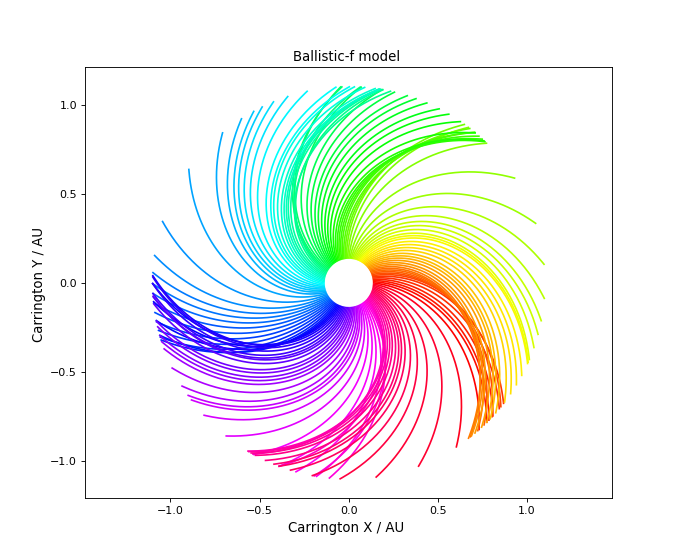

In [10]:
s_m = cmap()

fig, ax = plt.subplots()
for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_mat_bf[:, ii])*r, np.sin(phi_shift_mat_bf[:, ii])*r, color=s_m.to_rgba(p[ii]))

ax.set_title("Ballistic-f model ")
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
_ = plt.axis("equal")

plt.savefig('figures/ballistic_f.png')

# Ballistic-b, Mapping from 1 AU to 30 RS. 

In [11]:
phi_shift_mat_bb = compute_phi_shift_backward(p, r, v_at_eq, method="ballistic")

<IPython.core.display.Javascript object>


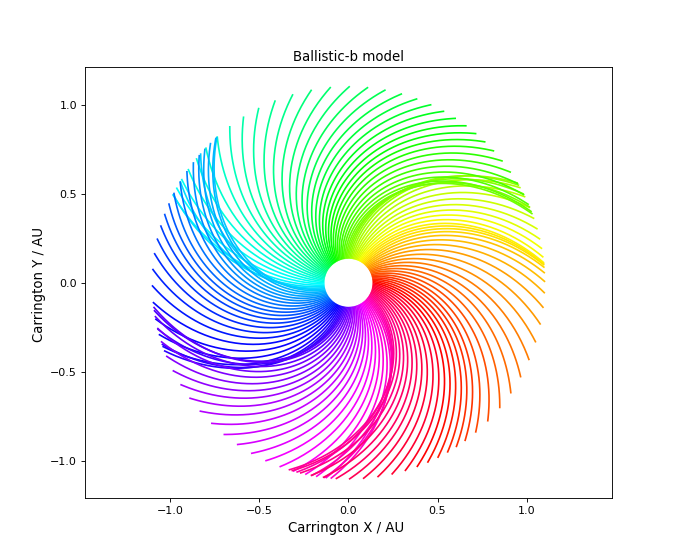

In [12]:
s_m = cmap()

fig, ax = plt.subplots()

for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_mat_bb[:, ii])*r, np.sin(phi_shift_mat_bb[:, ii])*r, color=s_m.to_rgba(p[ii]))

_ = ax.set_title("Ballistic-b model")
_ = ax.set_xlabel("Carrington X / AU ")
_ = ax.set_ylabel("Carrington Y / AU ")
_ = plt.axis("equal")

plt.savefig('figures/ballistic_b.png')

# MHD solution mapping. 

In [13]:
phi_shift_mat1 = compute_phi_shift_forward(p, r,  v_at_eq)

<IPython.core.display.Javascript object>


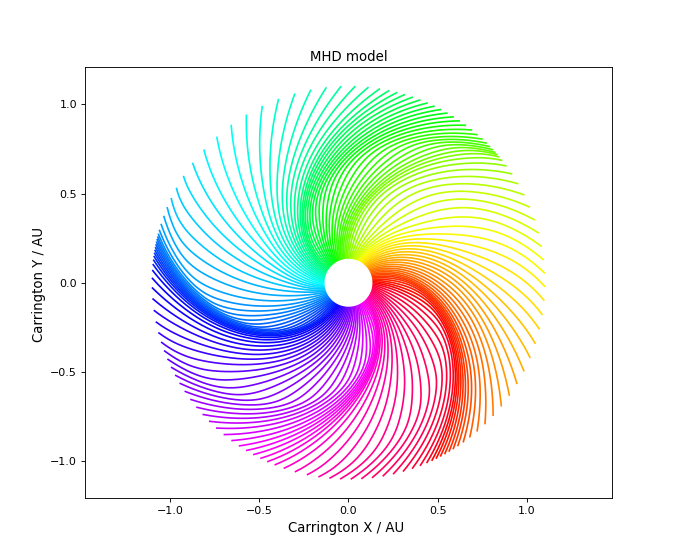

In [14]:
s_m = cmap()

fig, ax = plt.subplots()
for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_mat1[:, ii])*r, np.sin(phi_shift_mat1[:, ii])*r, color=s_m.to_rgba(p[ii]))

_ = ax.set_title("MHD model")
_ = ax.set_xlabel("Carrington X / AU ")
_ = ax.set_ylabel("Carrington Y / AU ")
_ = plt.axis("equal")

plt.savefig('figures/MHD.png')

# HUX-f model. Mapping from 30 RS to 1 AU. 

In [15]:
def apply_upwind_model(r_initial, r, p, omega_rot, dr_vec, dp_vec, alpha, rh, add_v_acc=True):
    """ Apply 1d upwind model to the inviscid burgers equation. r/phi grid."""
    
    v = np.zeros((len(r), len(p))) # initialize array vr.
    v[0, :] = r_initial

    if add_v_acc:
        v_acc = alpha * (v[0, :]*(1 - np.exp(-r[0]/rh)))
        v[0, :] = v_acc + v[0, :]

    for i in range(len(r) -1):
        for j in range(len(p)):

            if j == len(p) -1: # force periodicity 
                v[i+1, j] = v[i+1, 0]

            else:
                if (omega_rot*dr_vec[i])/(dp_vec[j]*v[i,j]) > 1: 
                    raise ValueError('CFL violated')

                frac1 = (v[i, j + 1] - v[i, j]) / v[i, j]
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
                v[i + 1, j] = v[i, j] + frac1*frac2
            
    return v

In [16]:
f_hux_f = apply_upwind_model(v_at_eq[:, 0], r, p, 2*np.pi/25.38, r[1:]- r[:-1], p[1:]-p[:-1], 0.15, 50/215.032)

In [17]:
phi_shift_mat2 = compute_phi_shift_forward(p, r, f_hux_f.T)

<IPython.core.display.Javascript object>


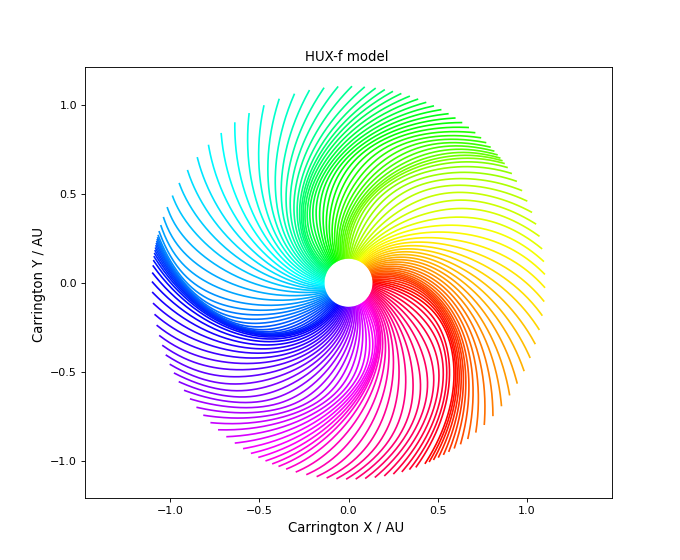

In [18]:
s_m = cmap()

fig, ax = plt.subplots()
for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_mat2[:, ii])*r, np.sin(phi_shift_mat2[:, ii])*r, color=s_m.to_rgba(p[ii]))


_ = ax.set_title("HUX-f model ")
_ = ax.set_xlabel("Carrington X / AU ")
_ = ax.set_ylabel("Carrington Y / AU ")
_ = plt.axis("equal")

plt.savefig('figures/HUX_f.png')

# HUX-b, Mapping from 1 AU to 30 RS. 

In [19]:
def apply_reverse_upwind_model(r_initial, omega_rot, dr_vec, dp_vec, alpha, rh, add_v_acc=True, r0=30/(215.032)):
    """ Apply 1d upwind model to the inviscid burgers equation. r/phi grid."""

    v = np.zeros((len(dr_vec) + 1, len(dp_vec) + 1))  # initialize array vr.
    v[0, :] = r_initial
    
    for i in range(len(dr_vec)):
        for j in range(len(dp_vec) + 1):

            if j != len(dp_vec):
                if (omega_rot * dr_vec[i]) / (dp_vec[j] * v[i, j]) > 1:
                    print('CFL violated', dr_vec[i] - dp_vec[j] * v[i, j] / omega_rot)
                    raise ValueError('CFL violated')

                frac2 = (omega_rot * dr_vec[i]) / dp_vec[j]
            else:
                frac2 = (omega_rot * dr_vec[i]) / dp_vec[0]

            frac1 = (v[i, j - 1] - v[i, j]) / v[i, j]
            v[i + 1, j] = v[i, j] + frac1 * frac2

    if add_v_acc:
        v_acc = alpha * (v[-1, :] * (1 - np.exp(-r0 / rh)))
        v[-1, :] = -v_acc + v[-1, :]

    return v

In [20]:
f_hux_b = apply_reverse_upwind_model(v_at_eq[:, -1], 2*np.pi/25.38, r[1:]-r[:-1], p[1:]-p[:-1], 0.15, 50/215.032, add_v_acc=True, r0=r[0]) 

In [21]:
phi_shift_mat = compute_phi_shift_backward(p, r, f_hux_b.T, method="hux")

<IPython.core.display.Javascript object>


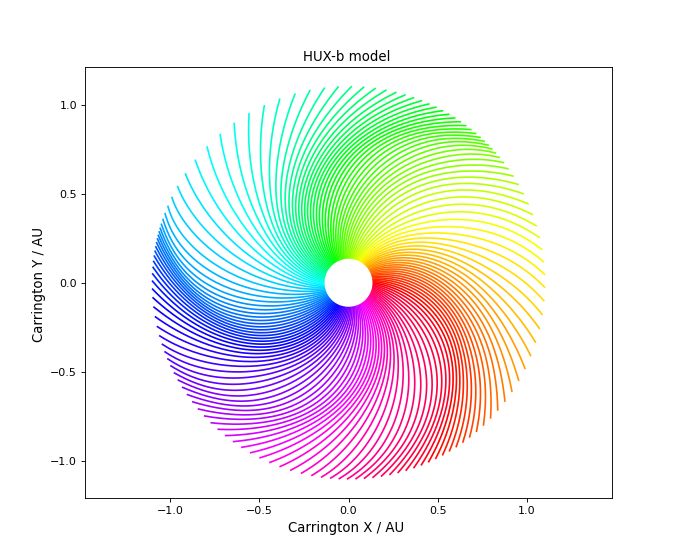

In [22]:
s_m = cmap()

fig, ax = plt.subplots()
for ii in range(len(p)):
    _ = ax.plot(np.cos(phi_shift_mat[:, ii])*r, np.sin(phi_shift_mat[:, ii])*r, color=s_m.to_rgba(p[ii]))
    
_ = ax.set_title("HUX-b model ")
_ = ax.set_xlabel("Carrington X / AU ")
_ = ax.set_ylabel("Carrington Y / AU ")
_ = plt.axis("equal")

plt.savefig('figures/HUX_b.png')

# Comparison of Ballistic-f, MHD-f and HUX-f final phi shift. 

In [23]:
phi_shift_mat_b = compute_phi_shift_forward(p, r, v_at_eq, method="ballistic")
phi_shift_mat_mhd = compute_phi_shift_forward(p, r, v_at_eq)
phi_shift_mat_hux = compute_phi_shift_forward(p, r, f_hux_f.T)

<IPython.core.display.Javascript object>


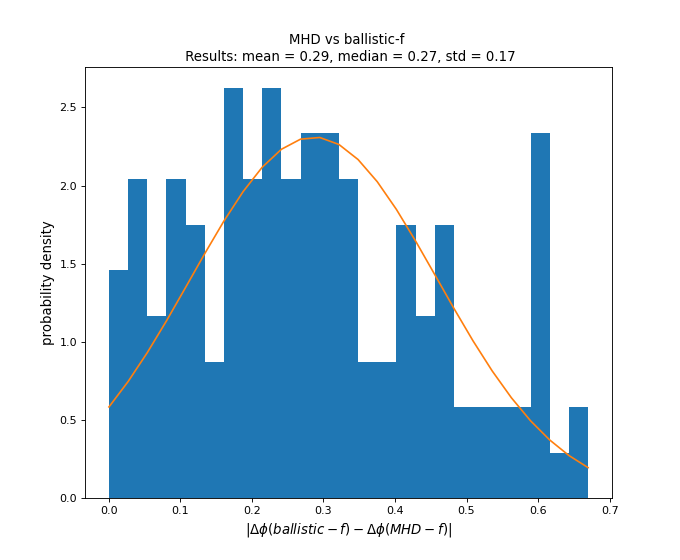

In [24]:
fig, ax = plt.subplots()
diff1 = np.abs(phi_shift_mat_b[-1] - phi_shift_mat_mhd[-1])
mu, sigma = scipy.stats.norm.fit(diff1)

n , bins, _ = ax.hist(np.abs(diff1), 25, density=1)
_ = ax.set_title("MHD vs ballistic-f \n Results: mean = %.2f, median = %.2f, std = %.2f" % (mu, np.median(diff1), sigma))
_ = ax.set_xlabel("$|\Delta \phi(ballistic-f) - \Delta \phi(MHD-f)|$")
_ = ax.set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax.plot(bins, best_fit_line)

plt.savefig('figures/ballistic_mhd_f_hist.png')

<IPython.core.display.Javascript object>


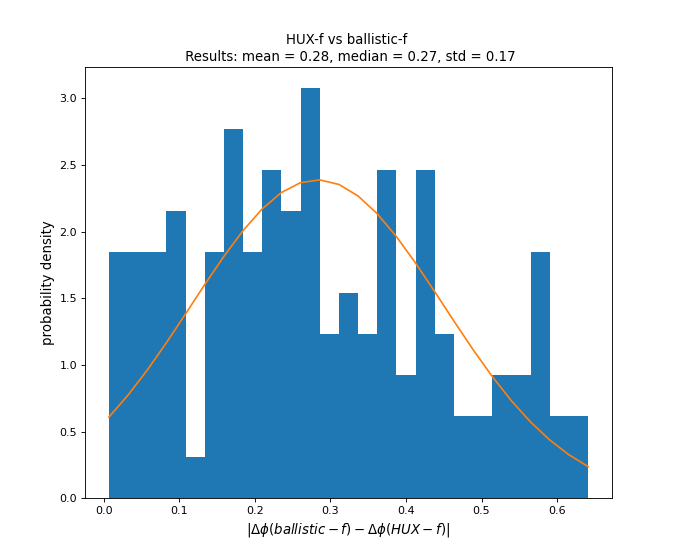

In [25]:
fig, ax = plt.subplots()
diff2 = np.abs(phi_shift_mat_b[-1] - phi_shift_mat_hux[-1])
mu, sigma = scipy.stats.norm.fit(diff2)

n , bins, _ = ax.hist(np.abs(diff2), 25, density=1)
_ = ax.set_title("HUX-f vs ballistic-f \n Results: mean = %.2f, median = %.2f, std = %.2f" % (mu, np.median(diff2), sigma))
_ = ax.set_xlabel("$|\Delta \phi(ballistic-f) - \Delta \phi(HUX-f)|$")
_ = ax.set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax.plot(bins, best_fit_line)

plt.savefig('figures/ballistic_hux_f_hist.png')

<IPython.core.display.Javascript object>


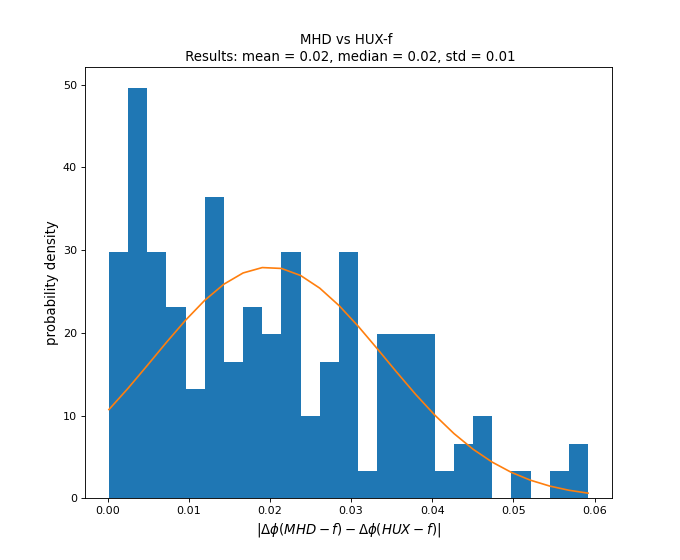

In [26]:
fig, ax = plt.subplots()
diff3 = np.abs(phi_shift_mat_mhd[-1] - phi_shift_mat_hux[-1])
mu, sigma = scipy.stats.norm.fit(diff3)

n , bins, _ = ax.hist(np.abs(diff3), 25, density=1)
_ = ax.set_title("MHD vs HUX-f \n Results: mean = %.2f, median = %.2f, std = %.2f" % (mu, np.median(diff3), sigma))
_ = ax.set_xlabel("$|\Delta \phi(MHD-f) - \Delta \phi(HUX-f)|$")
_ = ax.set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax.plot(bins, best_fit_line)

plt.savefig('figures/hux_mhd_f_hist.png')

In [27]:
def cdf(data, ax, label):
    data_size=len(data)
    # Set bins edges
    data_set=sorted(set(data))
    bins=np.append(data_set, data_set[-1]+1)
    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts=counts.astype(float)/data_size
    # Find the cdf
    cdf = np.cumsum(counts)
    # Plot the cdf
    ax.plot(bin_edges[:-1], cdf, label=label)

<IPython.core.display.Javascript object>


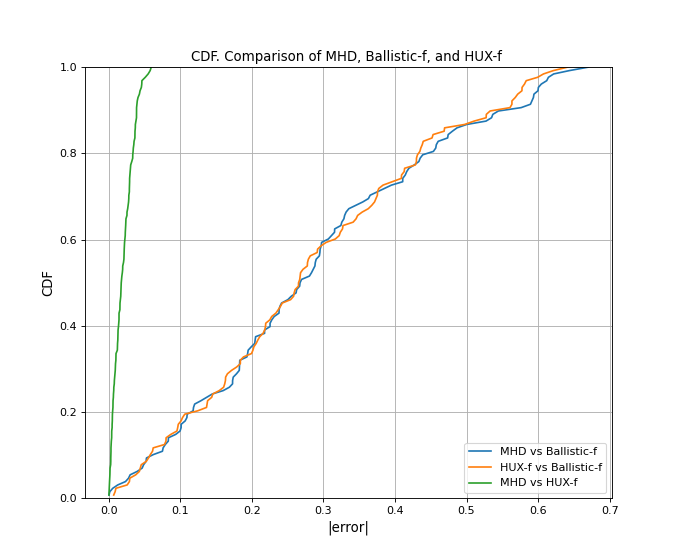

In [28]:
fig, ax = plt.subplots()
cdf(diff1, ax, label = "MHD vs Ballistic-f")
cdf(diff2, ax, label = "HUX-f vs Ballistic-f")
cdf(diff3, ax, label = "MHD vs HUX-f")
ax.set_ylim((0,1))
ax.set_ylabel("CDF")
ax.set_xlabel("|error|")
ax.grid(True)
ax.set_title("CDF. Comparison of MHD, Ballistic-f, and HUX-f ")
_ = plt.legend()

plt.savefig('figures/f_cdf.png')

# Comparison of Ballistic-b, MHD and HUX-b final phi shift. 

In [29]:
phi_shift_mat_b = compute_phi_shift_backward(p, r, v_at_eq, method="ballistic")
phi_shift_mat_mhd = compute_phi_shift_backward(p, r, v_at_eq, method="mhd")
phi_shift_mat_hux = compute_phi_shift_backward(p, r, f_hux_b.T, method="hux")

<IPython.core.display.Javascript object>


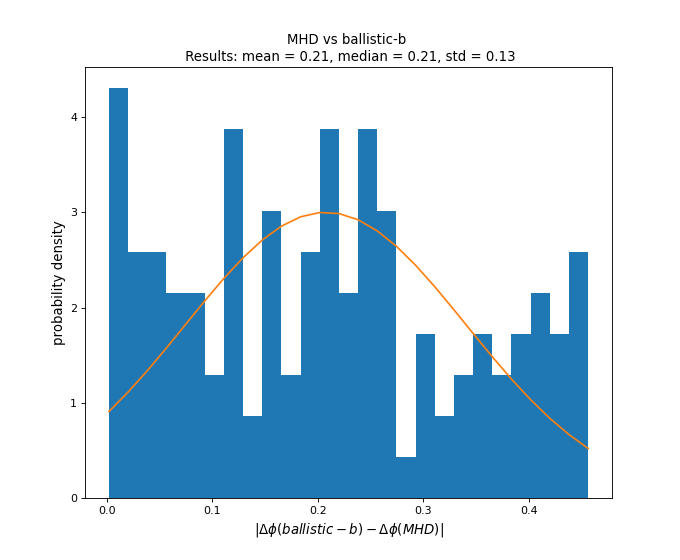

In [30]:
fig, ax = plt.subplots()
diff1 = np.abs(phi_shift_mat_b[-1] - phi_shift_mat_mhd[-1])
mu, sigma = scipy.stats.norm.fit(diff1)

n , bins, _ = ax.hist(np.abs(diff1), 25, density=1)
_ = ax.set_title("MHD vs ballistic-b \n Results: mean = %.2f, median = %.2f, std = %.2f" % (mu, np.median(diff1), sigma))
_ = ax.set_xlabel("$|\Delta \phi(ballistic-b) - \Delta \phi(MHD)|$")
_ = ax.set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax.plot(bins, best_fit_line)

plt.savefig('figures/ballistic_mhd_b_hist.png')

<IPython.core.display.Javascript object>


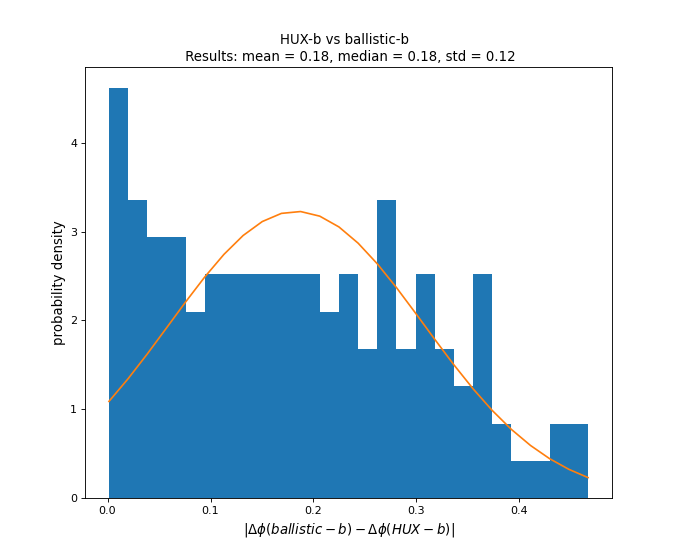

In [31]:
fig, ax = plt.subplots()
diff2 = np.abs(phi_shift_mat_b[-1] - phi_shift_mat_hux[-1])
mu, sigma = scipy.stats.norm.fit(diff2)

n , bins, _ = ax.hist(np.abs(diff2), 25, density=1)
_ = ax.set_title("HUX-b vs ballistic-b  \n Results: mean = %.2f, median = %.2f, std = %.2f" % (mu, np.median(diff2), sigma))
_ = ax.set_xlabel("$|\Delta \phi(ballistic-b) - \Delta \phi(HUX-b)|$")
_ = ax.set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax.plot(bins, best_fit_line)

plt.savefig('figures/ballistic_hux_b_hist.png')

<IPython.core.display.Javascript object>


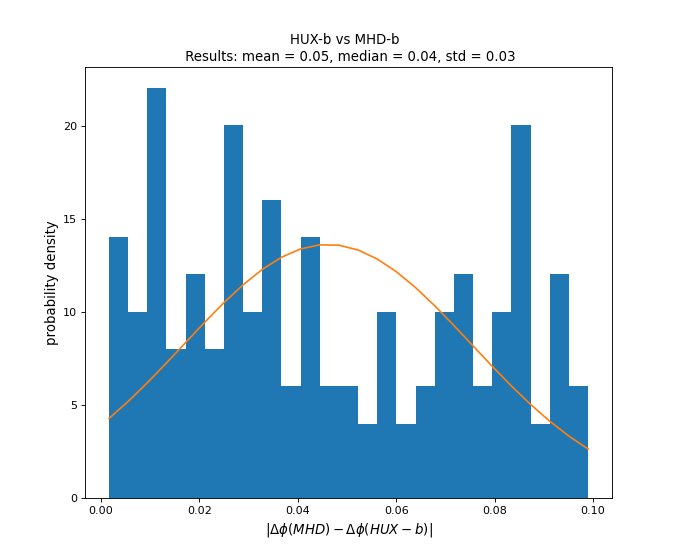

In [32]:
fig, ax = plt.subplots()
diff3 = np.abs(phi_shift_mat_mhd[-1] - phi_shift_mat_hux[-1])
mu, sigma = scipy.stats.norm.fit(diff3)

n , bins, _ = ax.hist(np.abs(diff3), 25, density=1)
_ = ax.set_title("HUX-b vs MHD-b  \n Results: mean = %.2f, median = %.2f, std = %.2f" % (mu, np.median(diff3), sigma))
_ = ax.set_xlabel("$|\Delta \phi(MHD) - \Delta \phi(HUX-b)|$")
_ = ax.set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax.plot(bins, best_fit_line)

plt.savefig('figures/hux_mhd_b_hist.png')

<IPython.core.display.Javascript object>


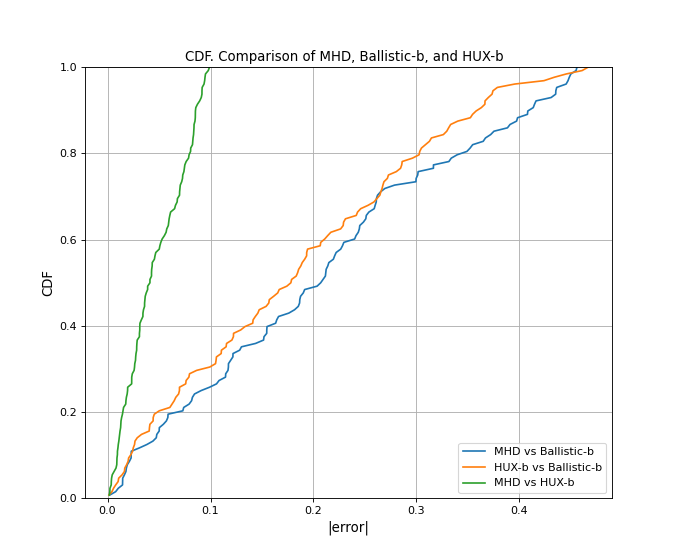

In [33]:
fig, ax = plt.subplots()
cdf(diff1, ax, label = "MHD vs Ballistic-b")
cdf(diff2, ax, label = "HUX-b vs Ballistic-b")
cdf(diff3, ax, label = "MHD vs HUX-b")
ax.set_ylim((0,1))
ax.set_ylabel("CDF")
ax.set_xlabel("|error|")
ax.grid(True)
ax.set_title("CDF. Comparison of MHD, Ballistic-b, and HUX-b  ")
_ = plt.legend()


plt.savefig('figures/cdf_b.png')